In [4]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import scipy

ModuleNotFoundError: No module named 'numpy'

In [14]:


# Définir les chemins 
base_path = "data"
dir_packet_loss = os.path.join(base_path, "packet_loss", "train_small")
dir_voice_origin = os.path.join(base_path, "voice_origin", "train_small")

# Fonction pour récupérer le premier fichier wav d'un dossier
def get_first_wav(directory):
    files = os.listdir(directory)
    for file in files:
        if file.endswith(".wav"):
            return os.path.join(directory, file)
    return None

# Récupérer les chemins des fichiers
file_pl = get_first_wav(dir_packet_loss)
file_vo = get_first_wav(dir_voice_origin)

# Charger les fichiers audio
if file_pl:
    y_pl, sr_pl = librosa.load(file_pl, sr=None) 
    print(f"Fichier Packet Loss chargé : {file_pl}")
    print(f"Dimensions : {y_pl.shape}, Fréquence : {sr_pl} Hz")

if file_vo:
    y_vo, sr_vo = librosa.load(file_vo, sr=None)
    print(f"Fichier Voice Origin chargé : {file_vo}")
    print(f"Dimensions : {y_vo.shape}, Fréquence : {sr_vo} Hz")

Fichier Packet Loss chargé : data\packet_loss\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
Dimensions : (80000,), Fréquence : 8000 Hz
Fichier Voice Origin chargé : data\voice_origin\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
Dimensions : (40000,), Fréquence : 4000 Hz


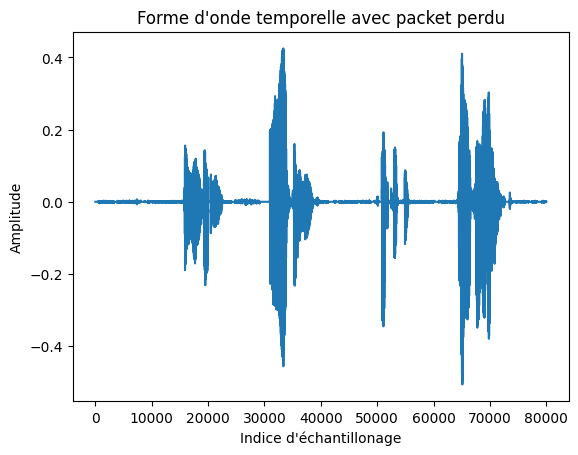

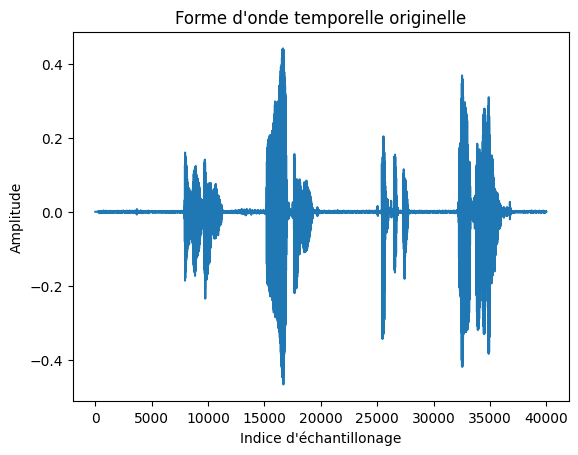

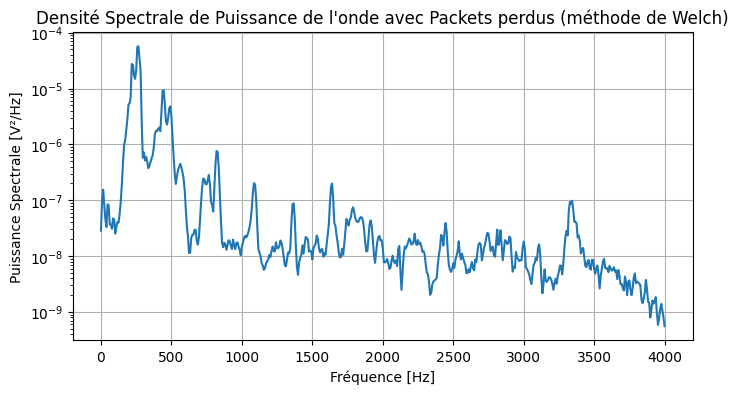

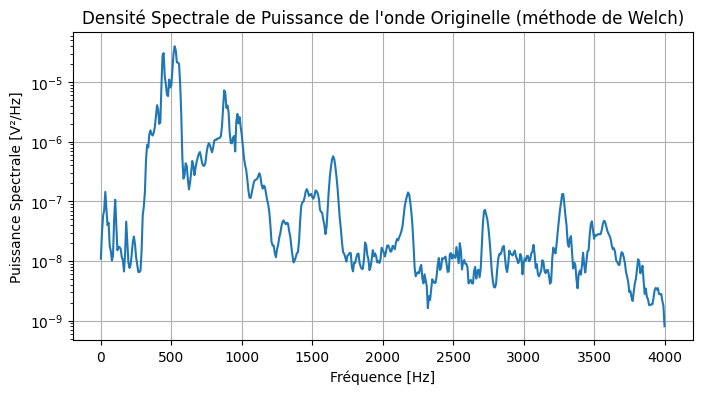

In [15]:
### FORME d'onde TEMPORELLE ###
T=[i for i in range(len(y_pl))]
plt.plot(T, y_pl)
plt.title("Forme d'onde temporelle avec packet perdu")
plt.xlabel("Indice d'échantillonage")
plt.ylabel("Amplitude")
plt.show()

plt.plot(T[0:len(y_vo)],y_vo)
plt.title("Forme d'onde temporelle originelle")
plt.xlabel("Indice d'échantillonage")
plt.ylabel("Amplitude")
plt.show()

### DENSITE SPECTRALE ###


# --- Calcul de la Densité Spectrale de Puissance (DSP) ---
frequencies, psd = scipy.signal.welch(y_pl, fs=8000, nperseg=1024)

# --- Affichage ---
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance de l'onde avec Packets perdus (méthode de Welch)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance Spectrale [V²/Hz]")
plt.grid(True)
plt.show()

# --- Calcul de la Densité Spectrale de Puissance (DSP) ---
frequencies, psd = scipy.signal.welch(y_vo, fs=8000, nperseg=1024)

# --- Affichage ---
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance de l'onde Originelle (méthode de Welch)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance Spectrale [V²/Hz]")
plt.grid(True)
plt.show()

C:\Users\valex\AppData\Local\Temp\ipykernel_6460\3670535170.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')


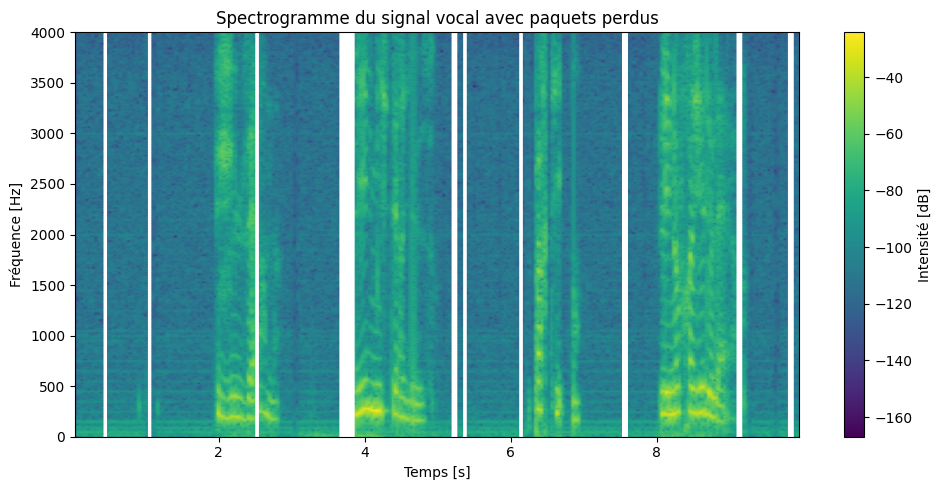

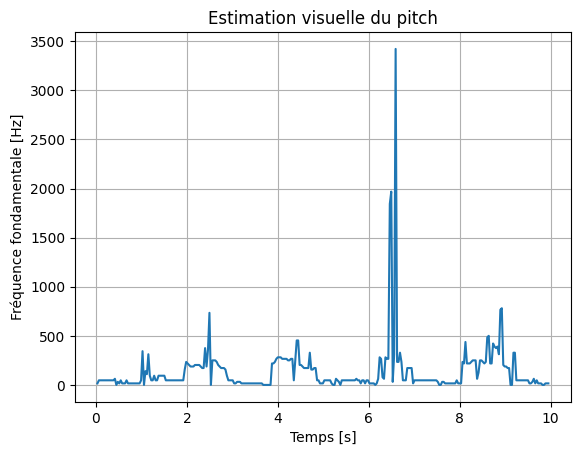

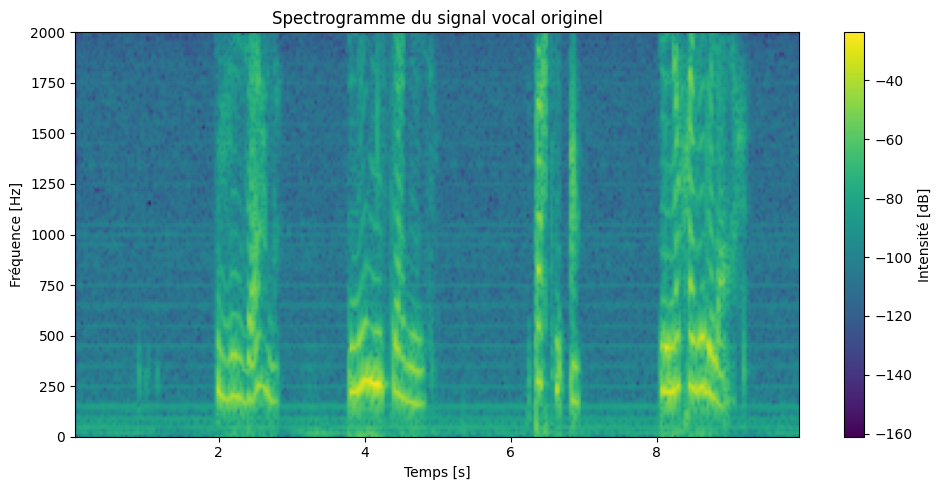

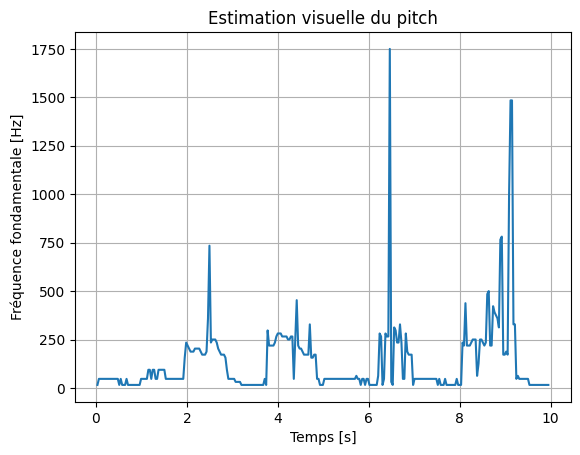

In [16]:
# --- Calcul du spectrogramme ---
f, t, Sxx_empty = scipy.signal.spectrogram(y_pl, fs=8000, nperseg=512, noverlap=256)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')
plt.title("Spectrogramme du signal vocal avec paquets perdus")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()

pitch_estim = f[np.argmax(Sxx_empty, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()


# --- Calcul du spectrogramme ---
f, t, Sxx = scipy.signal.spectrogram(y_vo, fs=4000, nperseg=256, noverlap=128)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogramme du signal vocal originel")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()
pitch_estim = f[np.argmax(Sxx, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()

Chirurgie audio : Remplacement de 21 frames...
Fichier mixé sauvegardé : data/packet_loss/train_small_results/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav


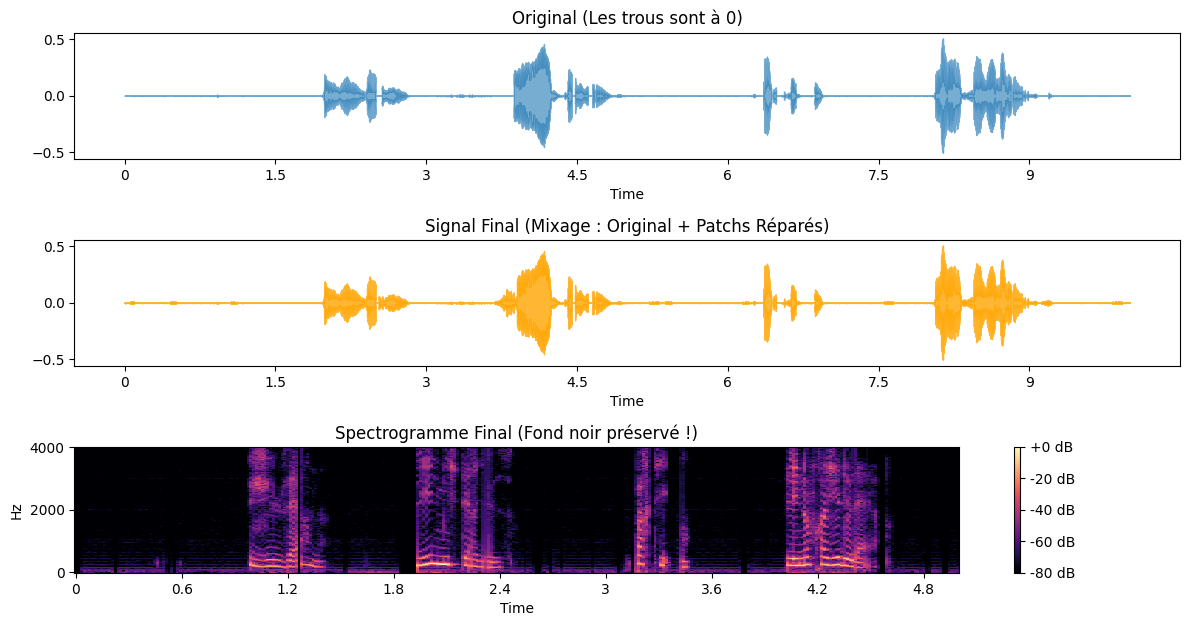

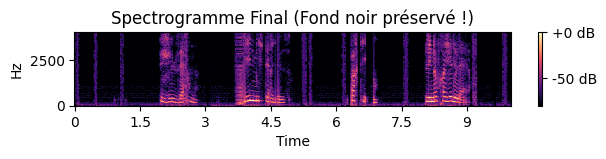

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def restoration_surgical_time_domain(input_path, output_path, sr=8000, n_mels=128):
    """
    1. Génère une version réparée complète (mais dégradée globalement).
    2. Utilise le signal original pour tout, sauf les trous.
    3. Remplace chirurgicalement les trous par le signal réparé.
    """
    
    # 1. Chargement Original
    y_orig, sr = librosa.load(input_path, sr=sr)
    
    # Paramètres STFT
    n_fft = 512
    hop_length = 256
    
    # 2. Création de la version réparée (processus identique au précédent)
    stft_matrix = librosa.stft(y_orig, n_fft=n_fft, hop_length=hop_length)
    S_linear = np.abs(stft_matrix)

    # Détection des trous (Masque sur les frames)
    # On considère un trou si l'énergie est < 0.5% du max
    energy_profile = np.max(S_linear, axis=0)
    if np.max(energy_profile) > 0:
        energy_profile_norm = energy_profile / np.max(energy_profile)
    else:
        energy_profile_norm = energy_profile
    
    mask_frames = energy_profile_norm < 0.00005 # True si c'est un trou
    
    # --- PROCESSUS DE RÉPARATION (Mel + Spline + dB) ---
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    S_mel = np.dot(mel_basis, S_linear)
    S_mel_db = librosa.power_to_db(S_mel**2, ref=np.max)
    
    # Interpolation Spline
    all_indices = np.arange(S_mel_db.shape[1])
    known_indices = all_indices[~mask_frames]
    missing_indices = all_indices[mask_frames]
    
    S_mel_db_fixed = S_mel_db.copy()
    
    # Si pas de trou, on rend l'original
    if len(missing_indices) == 0:
        return y_orig, y_orig, sr

    print(f"Chirurgie audio : Remplacement de {len(missing_indices)} frames...")

    for i in range(n_mels):
        values_known = S_mel_db[i, known_indices]
        if len(known_indices) > 3:
            try:
                f = interp1d(known_indices, values_known, kind='cubic', 
                             bounds_error=False, fill_value=-100)
                # On remplit et on clip pour éviter les explosions
                fixed_vals = np.clip(f(missing_indices), -100, 0)
                S_mel_db_fixed[i, missing_indices] = fixed_vals
            except:
                pass

    # Inversion complète vers Time Domain
    S_mel_fixed = librosa.db_to_power(S_mel_db_fixed)
    S_mel_fixed = np.sqrt(S_mel_fixed)
    S_linear_approx = librosa.feature.inverse.mel_to_stft(S_mel_fixed, sr=sr, n_fft=n_fft)
    y_repaired_full = librosa.griffinlim(S_linear_approx, n_iter=32, hop_length=hop_length, win_length=n_fft)

    # --- ETAPE CLÉ : LE MIXAGE TEMPOREL ---
    
    # 1. On s'assure que les deux signaux ont exactement la même taille
    # (Griffin-Lim peut parfois changer la longueur de quelques échantillons)
    y_repaired_full = librosa.util.fix_length(y_repaired_full, size=len(y_orig))
    
    # 2. On convertit le masque "Frames" (STFT) en masque "Samples" (Temps)
    # Cela nous dit quels échantillons précis sont dans les trous
    mask_samples = np.zeros(len(y_orig), dtype=bool)
    
    frames_indices = np.where(mask_frames)[0]
    # Conversion frame -> sample indices
    sample_indices = librosa.frames_to_samples(frames_indices, hop_length=hop_length)
    
    # On élargit un peu le masque échantillon pour couvrir la fenêtre FFT complète (n_fft)
    for start_sample in sample_indices:
        end_sample = min(start_sample + n_fft, len(y_orig))
        mask_samples[start_sample : end_sample] = True

    # 3. LE MIXAGE FINAL
    # On prend l'original par défaut
    y_final = y_orig.copy()
    
    # On injecte le signal réparé UNIQUEMENT là où le masque est True
    # Pour adoucir la transition, on pourrait faire un cross-fade, 
    # mais une copie directe est déjà bien meilleure que l'approche précédente.
    y_final[mask_samples] = y_repaired_full[mask_samples]

    # Sauvegarde
    if os.path.dirname(output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
    sf.write(output_path, y_final, sr)
    print(f"Fichier mixé sauvegardé : {output_path}")

    return y_orig, y_final, sr, S_linear, mask_samples

# --- EXÉCUTION ---
dir_packet_loss = "data/packet_loss/train_small/" 
if not os.path.exists(dir_packet_loss): os.makedirs(dir_packet_loss, exist_ok=True)
files = [f for f in os.listdir(dir_packet_loss) if f.endswith('.wav')]

if files:
    target = files[0]
    in_wav = os.path.join(dir_packet_loss, target)
    out_wav = "data/packet_loss/train_small_results/" + target
    
    y_orig, y_final, sr, S_orig, mask_samp = restoration_surgical_time_domain(in_wav, out_wav)

    # --- VISUALISATION ---
    plt.figure(figsize=(12, 8))
    
    # 1. Original (Zoom sur une zone)
    plt.subplot(4, 1, 1)
    librosa.display.waveshow(y_orig, sr=sr, alpha=0.6)
    plt.title("Original (Les trous sont à 0)")
    
    # 2. Signal Final (Mixé)
    plt.subplot(4, 1, 2)
    librosa.display.waveshow(y_final, sr=sr, color='orange', alpha=0.8)
    plt.title("Signal Final (Mixage : Original + Patchs Réparés)")

    # 3. Spectrogramme Final (Doit être NOIR là où c'était violet avant)
    

    plt.subplot(4, 1, 3)
    librosa.display.specshow(librosa.amplitude_to_db(S_orig, ref=np.max), 
                             sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Spectrogramme Final (Fond noir préservé !)")
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()


    plt.subplot(4, 1, 4)
    S_final = np.abs(librosa.stft(y_final, n_fft=512, hop_length=128))
    librosa.display.specshow(librosa.amplitude_to_db(S_final, ref=np.max), 
                             sr=sr, hop_length=128, x_axis='time', y_axis='hz')
    plt.title("Spectrogramme Final (Fond noir préservé !)")
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

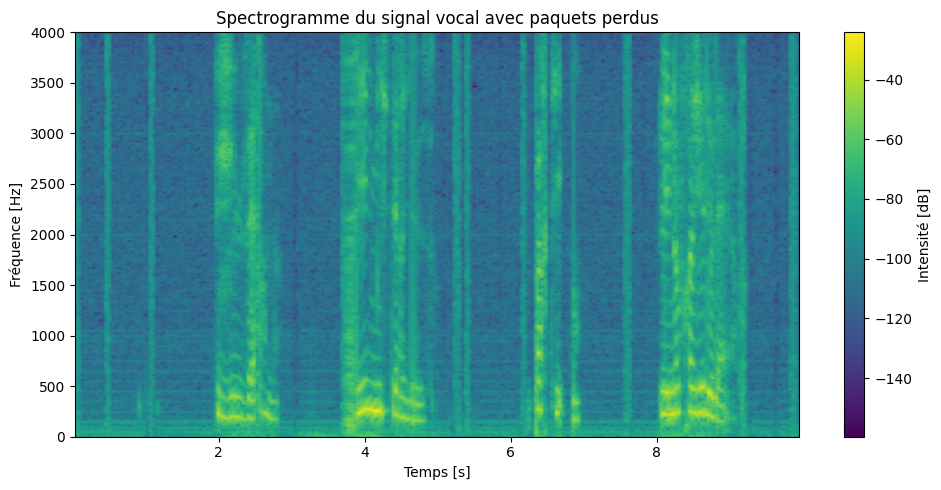

C:\Users\valex\AppData\Local\Temp\ipykernel_11180\171807449.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(S_origin), shading='gouraud')


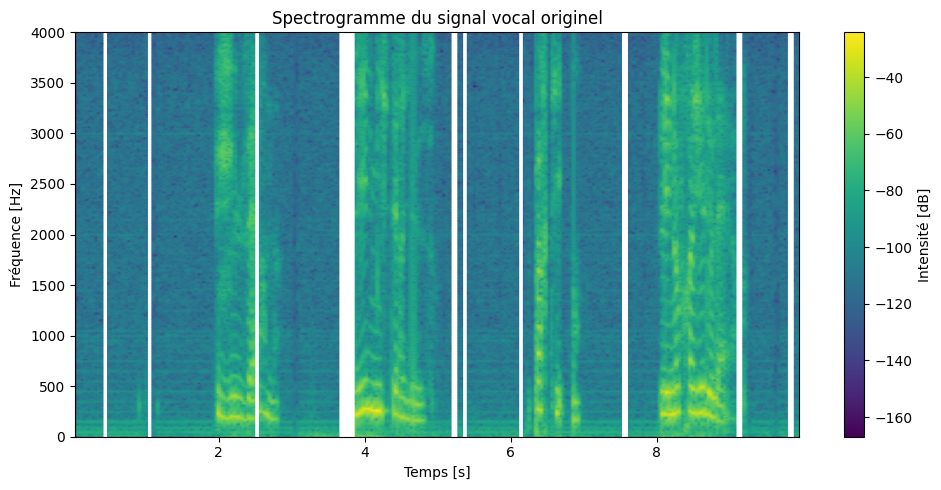

NameError: name 'Sxx' is not defined

In [8]:
import scipy

f, t, Sxx_empty = scipy.signal.spectrogram(y_final, fs=8000, nperseg=512, noverlap=256)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')
plt.title("Spectrogramme du signal vocal avec paquets perdus")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()

f, t, S_origin = scipy.signal.spectrogram(y_orig, fs=8000, nperseg=512, noverlap=256)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(S_origin), shading='gouraud')
plt.title("Spectrogramme du signal vocal originel")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()
pitch_estim = f[np.argmax(Sxx, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()

In [48]:
import os
import numpy as np
import librosa
import pandas as pd
from pesq import pesq
from pystoi import stoi
from tqdm import tqdm # Pour la barre de progression (pip install tqdm)

def calculate_metrics(ref_path, est_path, sr=8000):
    """
    Calcule PESQ et STOI pour une paire de fichiers.
    """
    # 1. Chargement
    # On force le chargement à la même fréquence
    ref, _ = librosa.load(ref_path, sr=sr)
    est, _ = librosa.load(est_path, sr=sr)
    
    # 2. Alignement de longueur (Sécurité)
    # PESQ plante si les longueurs sont différentes
    min_len = min(len(ref), len(est))
    ref = ref[:min_len]
    est = est[:min_len]
    
    # 3. Calcul du STOI (Intelligibilité)
    # Retourne une valeur entre 0.0 et 1.0
    try:
        stoi_score = stoi(ref, est, sr, extended=False)
    except Exception as e:
        print(f"Erreur STOI sur {os.path.basename(ref_path)}: {e}")
        stoi_score = np.nan

    # 4. Calcul du PESQ (Qualité)
    # Mode 'nb' (Narrowband) car sr=8000Hz. 
    # Si vous étiez à 16000Hz, il faudrait 'wb' (Wideband).
    try:
        # PESQ nécessite parfois un volume normalisé, mais la lib le gère souvent.
        pesq_score = pesq(sr, ref, est, 'nb')
    except Exception as e:
        # PESQ peut échouer si le signal est trop court (<0.25s) ou silence pur
        # print(f"Erreur PESQ sur {os.path.basename(ref_path)}: {e}") 
        pesq_score = np.nan
        
    return pesq_score, stoi_score

def evaluate_test_set(original_dir, repaired_dir, sr=8000):
    """
    Parcourt le dossier de test et calcule la moyenne des scores.
    """
    results = []
    
    # On liste les fichiers réparés
    files = [f for f in os.listdir(repaired_dir) if f.endswith('.wav')]
    
    if not files:
        print("Aucun fichier trouvé dans le dossier réparé.")
        return

    print(f"Évaluation de {len(files)} fichiers...")
    
    for filename in tqdm(files):
        path_est = os.path.join(repaired_dir, filename)
        
        # On suppose que le fichier original a le même nom
        # (Adaptez ici si vos noms diffèrent, ex: 'file_repaired.wav' vs 'file.wav')
        path_ref = os.path.join(original_dir, filename)
        
        if not os.path.exists(path_ref):
            print(f"Attention: Référence introuvable pour {filename}")
            continue
            
        # Calcul
        p_score, s_score = calculate_metrics(path_ref, path_est, sr)
        
        results.append({
            'filename': filename,
            'PESQ': p_score,
            'STOI': s_score
        })

    # Création d'un DataFrame pour l'analyse
    df = pd.DataFrame(results)
    
    # Affichage des moyennes
    print("\n--- RÉSULTATS GLOBAUX ---")
    print(f"Nombre de fichiers évalués : {len(df)}")
    print(f"PESQ Moyen : {df['PESQ'].mean():.3f}  (Max théorique: 4.5)")
    print(f"STOI Moyen : {df['STOI'].mean():.3f}  (Max théorique: 1.0)")
    
    return df

# --- EXEMPLE D'UTILISATION ---

# Dossier contenant les originaux PARFAITS (sans trous)
# Attention: Il faut comparer avec l'original SANS perte, pas celui avec les trous !
dir_ground_truth = "data/packet_loss/original_clean/" 

# Dossier contenant vos résultats (Mel + Spline + Mixage)
dir_repaired = "data/packet_loss/results_time_mask/"

# Si vous n'avez pas le dossier "clean", vous ne pouvez pas calculer de métriques justes.
# On compare toujours : (Signal Prédit) vs (Signal Réel sans défaut)

if os.path.exists(dir_ground_truth) and os.path.exists(dir_repaired):
    df_results = evaluate_test_set(dir_ground_truth, dir_repaired, sr=8000)
    
    # Sauvegarder en CSV si besoin
    # df_results.to_csv("resultats_evaluation.csv", index=False)
else:
    print("Vérifiez vos chemins de dossiers.")

ModuleNotFoundError: No module named 'pesq'